In [14]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [15]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline 
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_graphviz
import matplotlib.pyplot as plt
import seaborn as sns

import lightgbm as lgbm
import gc
import xgboost as xgb

In [16]:
items           = pd.read_csv('items.csv')
item_categories = pd.read_csv('item_categories.csv')
shops           = pd.read_csv('shops.csv')
sales_train     = pd.read_csv('sales_train_v2.csv')
test            = pd.read_csv('test.csv')
sample_submission            = pd.read_csv('sample_submission.csv')

In [17]:
transactions = sales_train.copy()
transactions[['day','month', 'year']] = transactions['date'].str.split('.', expand=True).astype(int)


In [92]:
w_cat_ids = transactions.set_index('item_id').join(items.set_index('item_id'))
w_cat_ids = w_cat_ids.reset_index()
w_cat_ids['row_id'] = w_cat_ids.index
w_cat_ids['y'] = w_cat_ids.groupby(['month', 'item_id', 'shop_id'])['item_cnt_day'].transform('sum').clip(0,20)

In [93]:
#w_cat_ids['item_mean'] = w_cat_ids.groupby(['month', 'item_id'])['item_cnt_day']
item_means = (w_cat_ids.groupby(['month', 'item_id'])['item_cnt_day'].sum().groupby(level=[0,1]).mean() / w_cat_ids['shop_id'].nunique()).reset_index(name = 'item_mean_month')

w_cat_ids = pd.merge(w_cat_ids, item_means, on=['month','item_id'], how='left')

In [94]:
w_cat_ids['item_ids_linked_to_shop'] = w_cat_ids.groupby(['shop_id'])['item_id'].transform('nunique')
shop_means = w_cat_ids.groupby(['month', 'shop_id'])['item_cnt_day'].sum().groupby(level=[0,1]).mean().reset_index(name = 'shop_mean_month')

w_cat_ids = pd.merge(w_cat_ids, shop_means, on=['month','shop_id'], how='left')

w_cat_ids['shop_mean_month'] = w_cat_ids['shop_mean_month'] / w_cat_ids['item_ids_linked_to_shop']

In [95]:
w_cat_ids['item_ids_in_cat'] = w_cat_ids.groupby(['item_category_id'])['item_id'].transform('nunique')
cat_means = w_cat_ids.groupby(['month', 'item_category_id'])['item_cnt_day'].sum().groupby(level=[0,1]).mean().reset_index(name = 'cat_mean_month')


w_cat_ids = pd.merge(w_cat_ids, cat_means, on=['month','item_category_id'], how='left')

w_cat_ids['cat_mean_month'] = w_cat_ids['cat_mean_month'] / w_cat_ids['item_ids_in_cat']


In [96]:
lags = [1,2]

for lag in lags:
    lags = w_cat_ids.sort_values(by='month').groupby(['item_id', 'month'])['item_mean_month'].first().groupby(level=[0]).shift(lag)
    w_cat_ids.set_index(['item_id', 'month'], inplace=True)
    w_cat_ids["item_mean_month_minus_%d" % (lag)]  = lags
    w_cat_ids.reset_index(inplace=True)

In [108]:
lags = [1,2]

for lag in lags:
    lags = w_cat_ids.sort_values(by='month').groupby(['shop_id', 'month'])['shop_mean_month'].first().groupby(level=[0]).shift(lag)
    w_cat_ids.set_index(['shop_id', 'month'], inplace=True)
    w_cat_ids["shop_mean_month_minus_%d" % (lag)]  = lags
    w_cat_ids.reset_index(inplace=True)

In [109]:
lags = [1,2]

for lag in lags:
    lags = w_cat_ids.sort_values(by='month').groupby(['item_category_id', 'month'])['cat_mean_month'].first().groupby(level=[0]).shift(lag)
    w_cat_ids.set_index(['item_category_id', 'month'], inplace=True)
    w_cat_ids["cat_mean_month_minus_%d" % (lag)]  = lags
    w_cat_ids.reset_index(inplace=True)

In [110]:
import datetime
months = []
for i in range(1,13):
    months.append((i, str.lower(datetime.date(2008, i, 1).strftime('%B'))))
    
for i, month in months:
    w_cat_ids[month] = w_cat_ids.month == i
    
years = w_cat_ids.year.unique()
for year in years:
    w_cat_ids[year] = w_cat_ids.year == year

In [111]:
 w_cat_ids[(w_cat_ids.shop_id == 31) & (w_cat_ids.item_id==20949)].groupby('month').first().sort_values(by='month')\
    [['item_mean_month','item_mean_month_minus_1', 'item_mean_month_minus_2', 'shop_mean_month', 'shop_mean_month_minus_1', 'shop_mean_month_minus_2',\
     'cat_mean_month', 'cat_mean_month_minus_1', 'cat_mean_month_minus_2']]

,item_mean_month,item_mean_month_minus_1,item_mean_month_minus_2,shop_mean_month,shop_mean_month_minus_1,shop_mean_month_minus_2,cat_mean_month,cat_mean_month_minus_1,cat_mean_month_minus_2
month,,,,,,,,,
1,253.300000,NaN,NaN,2.012001,NaN,NaN,2557.833333,NaN,NaN
2,160.933333,253.300000,NaN,1.962542,2.012001,NaN,1624.500000,2557.833333,NaN
3,160.683333,160.933333,253.300000,2.053760,1.962542,2.012001,1623.833333,1624.500000,2557.833333
4,170.450000,160.683333,160.933333,1.793771,2.053760,1.962542,1704.666667,1623.833333,1624.500000
5,221.950000,170.450000,160.683333,1.635405,1.793771,2.053760,2221.333333,1704.666667,1623.833333
6,310.150000,221.950000,170.450000,1.660169,1.635405,1.793771,3101.833333,2221.333333,1704.666667
7,276.533333,310.150000,221.950000,1.563749,1.660169,1.635405,2765.333333,3101.833333,2221.333333
8,285.550000,276.533333,310.150000,1.653996,1.563749,1.660169,2855.500000,2765.333333,3101.833333
9,298.433333,285.550000,276.533333,1.823807,1.653996,1.563749,2984.333333,2855.500000,2765.333333


In [112]:
w_cat_ids.columns

Index([       'item_category_id',                   'month',
                       'shop_id',                 'item_id',
                          'date',          'date_block_num',
                    'item_price',            'item_cnt_day',
                           'day',                    'year',
                     'item_name',                  'row_id',
                             'y',         'item_mean_month',
       'item_ids_linked_to_shop',         'shop_mean_month',
               'item_ids_in_cat',          'cat_mean_month',
       'item_mean_month_minus_1', 'item_mean_month_minus_2',
       'shop_mean_month_minus_1', 'shop_mean_month_minus_2',
        'cat_mean_month_minus_1',  'cat_mean_month_minus_2',
                       'january',                'february',
                         'march',                   'april',
                           'may',                    'june',
                          'july',                  'august',
                     'se

In [113]:
features = [       'item_category_id',                   'month',
                       'shop_id',                 'item_id',
                      'year',
               'item_mean_month', 
               'shop_mean_month',       
                'cat_mean_month', 'item_mean_month_minus_1',
       'item_mean_month_minus_2', 'shop_mean_month_minus_1',
       'shop_mean_month_minus_2',  'cat_mean_month_minus_1',
        'cat_mean_month_minus_2',                 'january',
                      'february',                   'march',
                         'april',                     'may',
                          'june',                    'july',
                        'august',               'september',
                       'october',                'november',
                      'december',                      2014,
                            2015,                      2013]

In [114]:
 w_cat_ids[features].head(10)

,item_category_id,month,shop_id,item_id,year,item_mean_month,shop_mean_month,cat_mean_month,item_mean_month_minus_1,item_mean_month_minus_2,...,june,july,august,september,october,november,december,2014,2015,2013
0,40,9,54,0,2014,0.016667,0.927721,8.637188,NaN,NaN,...,False,False,False,True,False,False,False,True,False,False
1,76,4,55,1,2014,0.033333,2.364232,1.103976,NaN,NaN,...,False,False,False,False,False,False,False,True,False,False
2,76,4,55,1,2014,0.033333,2.364232,1.103976,NaN,NaN,...,False,False,False,False,False,False,False,True,False,False
3,76,7,55,1,2014,0.016667,1.932494,1.538226,0.033333,NaN,...,False,True,False,False,False,False,False,True,False,False
4,76,8,55,1,2014,0.016667,2.229723,1.614679,0.016667,0.033333,...,False,False,True,False,False,False,False,True,False,False
5,76,9,55,1,2014,0.016667,5.001511,1.746177,0.016667,0.016667,...,False,False,False,True,False,False,False,True,False,False
6,76,10,55,1,2014,0.016667,3.585390,1.801223,0.016667,0.016667,...,False,False,False,False,True,False,False,True,False,False
7,40,8,54,2,2014,0.016667,1.008584,9.763094,NaN,NaN,...,False,False,True,False,False,False,False,True,False,False
8,40,11,54,2,2014,0.016667,1.036356,8.107977,0.016667,NaN,...,False,False,False,False,False,True,False,True,False,False
9,40,7,54,3,2014,0.016667,0.895405,9.778606,NaN,NaN,...,False,True,False,False,False,False,False,True,False,False


In [115]:
test_w_cat_ids = test.set_index('item_id').join(items.set_index('item_id'))
test_w_cat_ids['item_id'] = test_w_cat_ids.index

In [116]:
# categories test
cat_counts_test = pd.DataFrame(test_w_cat_ids.groupby('item_category_id').size().reset_index(name="counts"))
cat_counts_test['percentage'] = cat_counts_test['counts'] * 100 / cat_counts_test.counts.sum()

# categories train
cat_counts = pd.DataFrame(w_cat_ids.groupby('item_category_id').size().reset_index(name="counts"))
cat_counts['percentage'] = cat_counts['counts'] * 100 / cat_counts.counts.sum()

combined  = pd.merge(cat_counts, cat_counts_test,  how='left', left_on=['item_category_id'], right_on = ['item_category_id'])
combined = combined.rename(index= str, columns={"counts_x": "total_train", "percentage_x": "%train", "counts_y": "total_test", "percentage_y": "%test"})

shares = {}
for _, row in combined.iterrows():
    shares[row['item_category_id']] = row['%test']

no_nans = [v for v in shares.values() if not np.isnan(v)] 
#sorted(no_nans, reverse=True)

val_len = 25000

    
def get_share_of_group(group):
    #print(type(group))
    cat_id = np.unique(group[['item_category_id']])[0]
    share = shares[cat_id]

    #print(share)
    needed = val_len * share / 100
    #print(needed)

    if len(group) <= needed:
        print("Needed %d but only %d available for cat_id %d with share %f" % (needed, len(group), cat_id, share))
    #else:
        #print("OK")
    if np.isnan(needed):
        return group.head(0)
    return group.head(int(needed))


#val_indices = w_cat_ids[w_cat_ids['date_block_num'].isin([32,33])].groupby("item_category_id").apply(get_share_of_group).index
val_indices = w_cat_ids[w_cat_ids['date_block_num'].isin([32,33])].groupby("item_category_id").apply(get_share_of_group)['row_id'].values

Needed 4 but only 1 available for cat_id 27 with share 0.019608
Needed 171 but only 145 available for cat_id 45 with share 0.686275
Needed 1093 but only 820 available for cat_id 58 with share 4.372549
Needed 39 but only 33 available for cat_id 60 with share 0.156863
Needed 299 but only 241 available for cat_id 76 with share 1.196078
Needed 78 but only 66 available for cat_id 77 with share 0.313725
Needed 240 but only 134 available for cat_id 78 with share 0.960784


In [117]:
x = w_cat_ids[features] 
y = w_cat_ids['y']


x_train = x[~x.index.isin(val_indices)]
y_train = y[~y.index.isin(val_indices)]

x_val = x[x.index.isin(val_indices)]
y_val = y[y.index.isin(val_indices)]

In [118]:
lgtrain = lgbm.Dataset(x_train, label=y_train, categorical_feature=[0,1,2,3,4])
lgval = lgbm.Dataset(x_val, label=y_val, categorical_feature=[0,1,2,3,4])



#[0.00542047893814942, 29, 24, 0.39949465609514856, 1, 0.67943500, 10]
params = {
        "num_threads": 8,
        "verbosity": -1,
        #"zero_as_missing": "true",
        "boosting":'gbdt',
        "objective" : "regression",
        "metric" : "rmse",
        "seed": 42,
        "learning_rate" : 0.05
}

evals_result = {}
model_lgb = lgbm.train(params, lgtrain, 10000, 
                      valid_sets=[lgval], 
                      early_stopping_rounds=100, 
                      verbose_eval=100, 
                      evals_result=evals_result)

/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:752: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 2.24987
[200]	valid_0's rmse: 2.17874
[300]	valid_0's rmse: 2.14066
[400]	valid_0's rmse: 2.11068
[500]	valid_0's rmse: 2.08416
[600]	valid_0's rmse: 2.07147
[700]	valid_0's rmse: 2.06139
[800]	valid_0's rmse: 2.0515
[900]	valid_0's rmse: 2.04723
[1000]	valid_0's rmse: 2.04284
[1100]	valid_0's rmse: 2.03987
[1200]	valid_0's rmse: 2.03714
[1300]	valid_0's rmse: 2.03407
[1400]	valid_0's rmse: 2.03126
[1500]	valid_0's rmse: 2.02652
[1600]	valid_0's rmse: 2.02195
[1700]	valid_0's rmse: 2.01902
[1800]	valid_0's rmse: 2.01673
[1900]	valid_0's rmse: 2.01555
[2000]	valid_0's rmse: 2.01257
[2100]	valid_0's rmse: 2.00949
[2200]	valid_0's rmse: 2.00761
[2300]	valid_0's rmse: 2.00601
[2400]	valid_0's rmse: 2.00483
[2500]	valid_0's rmse: 2.00182
[2600]	valid_0's rmse: 1.99921
[2700]	valid_0's rmse: 1.99818
[2800]	valid_0's rmse: 1.99718
[2900]	valid_0's rmse: 1.99684
[3000]	valid_0's rmse: 1.9951
[3100]	valid_0's r

In [136]:
test_w_cat_ids = test.set_index('item_id').join(items.set_index('item_id'))
test_w_cat_ids['item_id'] = test_w_cat_ids.index

In [137]:
test_w_cat_ids['month'] = 11
test_w_cat_ids['year'] = 2015

In [138]:
features

['item_category_id',
 'month',
 'shop_id',
 'item_id',
 'year',
 'item_mean_month',
 'shop_mean_month',
 'cat_mean_month',
 'item_mean_month_minus_1',
 'item_mean_month_minus_2',
 'shop_mean_month_minus_1',
 'shop_mean_month_minus_2',
 'cat_mean_month_minus_1',
 'cat_mean_month_minus_2',
 'january',
 'february',
 'march',
 'april',
 'may',
 'june',
 'july',
 'august',
 'september',
 'october',
 'november',
 'december',
 2014,
 2015,
 2013]

In [139]:
item_month_level = w_cat_ids[(w_cat_ids.month == 11)].drop_duplicates(['item_id'])[['item_id','item_mean_month', 'item_mean_month_minus_1', 'item_mean_month_minus_2']]

test_w_cat_ids = pd.merge(test_w_cat_ids, item_month_level, on=['item_id'], how='left')

test_w_cat_ids['item_mean_month'] = test_w_cat_ids['item_mean_month'].fillna(test_w_cat_ids['item_mean_month'].mean())
test_w_cat_ids['item_mean_month_minus_1'] = test_w_cat_ids['item_mean_month_minus_1'].fillna(test_w_cat_ids['item_mean_month_minus_1'].mean())
test_w_cat_ids['item_mean_month_minus_2'] = test_w_cat_ids['item_mean_month_minus_2'].fillna(test_w_cat_ids['item_mean_month_minus_2'].mean())

In [142]:
shop_month_level = w_cat_ids[(w_cat_ids.month == 11)].drop_duplicates(['shop_id'])[['shop_id','shop_mean_month', 'shop_mean_month_minus_1', 'shop_mean_month_minus_2']]

test_w_cat_ids = pd.merge(test_w_cat_ids, shop_month_level, on=['shop_id'], how='left')

In [144]:
cat_month_level = w_cat_ids[(w_cat_ids.month == 11)].drop_duplicates(['item_category_id'])[['item_category_id','cat_mean_month', 'cat_mean_month_minus_1', 'cat_mean_month_minus_2']]

test_w_cat_ids = pd.merge(test_w_cat_ids, cat_month_level, on=['item_category_id'], how='left')

In [148]:
for _, month in months:
    test_w_cat_ids[month] = False
    
test_w_cat_ids['november'] = True

for year in years:
    test_w_cat_ids[year] = False
    
test_w_cat_ids[2015] = True


In [149]:
columns = test_w_cat_ids.columns
percent_missing = test_w_cat_ids.isna().sum() * 100 / len(test_w_cat_ids)
pd.DataFrame({'column_name': columns,
                                 'percent_missing': percent_missing})

,column_name,percent_missing
ID,ID,0.000000
shop_id,shop_id,0.000000
item_name,item_name,0.000000
item_category_id,item_category_id,0.000000
item_id,item_id,0.000000
month,month,0.000000
year,year,0.000000
item_mean_month,item_mean_month,0.000000
item_mean_month_minus_1,item_mean_month_minus_1,0.000000
item_mean_month_minus_2,item_mean_month_minus_2,0.000000


In [150]:
preds = np.clip(model_lgb.predict(test_w_cat_ids[features]), 0,20)

In [151]:
submission = test.loc[:,['ID']]
submission['item_cnt_month'] = preds.astype(int)

submission.to_csv('submission.csv', index=False)

Plotting feature importances...


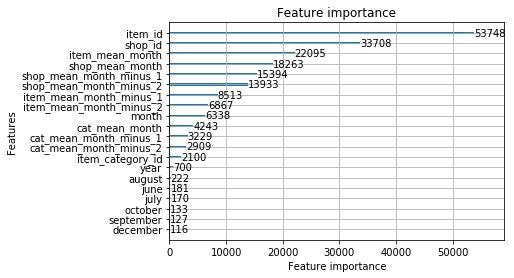

In [146]:
print('Plotting feature importances...')
ax = lgbm.plot_importance(model_lgb, max_num_features=20)
plt.show()

3.45 val > 3.70 submit
3.06 val > 3.65 submit